# Load library

In [2]:
# Load library:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, recall_score
import pandas as pd
import pygeostat as gs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
%pylab inline --no-import-all
from subprocess import check_output
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import os

Populating the interactive namespace from numpy and matplotlib


In [3]:
griddef = gs.GridDef(griddef="100 0 1 \n100 0 1 \n1 0.5 1")
griddef

Pygeostat GridDef:
100 0.0 1.0 
100 0.0 1.0 
1 0.5 1.0

# Load Models 

## Major direction 

In [4]:
# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model

# load model
CNN_Major = load_model('CNN_2_Major_160.h5')
# summarize model.
CNN_Major.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 8)       80        
_________________________________________________________________
re_lu (ReLU)                 (None, 100, 100, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        4

## Minor direction 

In [5]:
# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model

# load model
CNN_Minor = load_model('CNN_2_Minor_70.h5')
# summarize model.
CNN_Minor.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 8)       80        
_________________________________________________________________
re_lu (ReLU)                 (None, 100, 100, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        4

# Data Columns

In [6]:
data = gs.DataFile('10varcalc1.out')

In [7]:
ind = data['Variogram Index']

In [8]:
co = data['Lag Distance']

In [9]:
def open_vmodel(vmodel_file,n_lag):
    list_ = []
    index = []
    vargplot = open(vmodel_file)
    for i in range(n_lag):
        dm = vargplot.readline().split()
        list_.append(list(map(float,dm))) 
    result = pd.DataFrame(list_)
    result.columns = ['Variogram Index','Lag Distance','Variogram Value']
    istart = 0

        
    return pd.DataFrame(result)

# Load Inverse Distance grid : Input data

In [10]:
from scipy.sparse import coo_matrix

In [11]:
row = gs.DataFile('10addcoord1.out')['X']
col = gs.DataFile('10addcoord1.out')['Y']

## Major

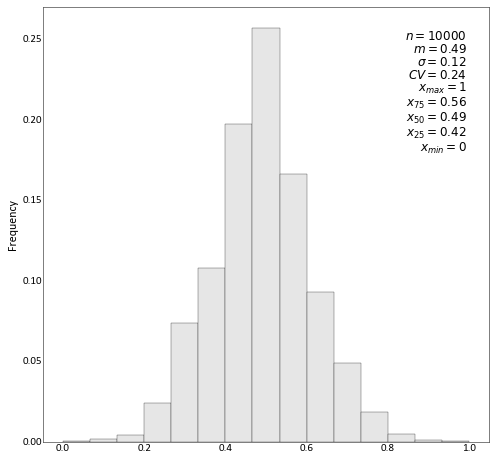

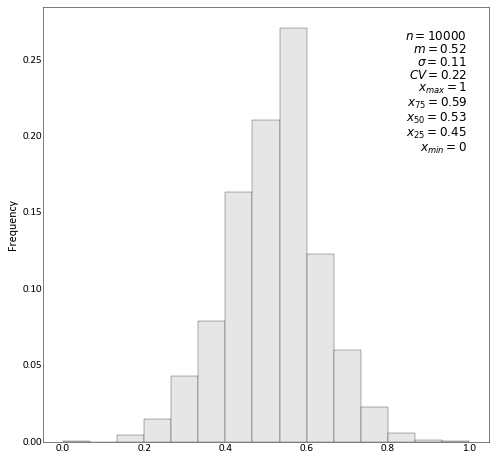

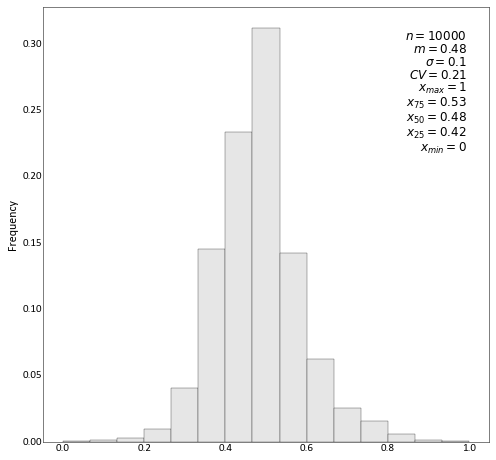

In [12]:
# define a list of the dataset types
data_sets = ['Regular', 'Random', 'Original']

for data_set in data_sets:

    Pred_list = []

    # loop through the files and append to the Pred_list
    for i in range(21):
        g = gs.DataFile('{}/IDW_Rot/IDW_walker_all_U_{}.out'.format(data_set, i))['Estimate']
        Pred_list.append(g)

    Pred_list_2 = []
    for i in range(21):
        g = coo_matrix((Pred_list[i], (row, col)), shape=(100,100)).toarray()
        Pred_list_2.append(g)

    X_train = np.array([Pred_list_2[k] for k in range(21)])

    fi_min = []
    for i in range(21):
        g_min = X_train[i].min()
        fi_min.append(g_min)

    fi_max = []
    for i in range(21):
        g_max = X_train[i].max()
        fi_max.append(g_max)

    fi_norm = []
    for i in range(21):
        g_norm = (X_train[i] - fi_min[i]) / (fi_max[i] - fi_min[i]) * 2 - 1
        fi_norm.append(g_norm)

    X_train_norm = np.array([fi_norm[i] for i in range(21)])

    fi_min_norm = []
    for i in range(21):
        g_min_norm = X_train_norm[i].min()
        fi_min_norm.append(g_min_norm)

    fi_max_norm = []
    for i in range(21):
        g_max_norm = X_train_norm[i].max()
        fi_max_norm.append(g_max_norm)

    fi_norm_2 = []
    for i in range(21):
        g_norm_2 = (X_train_norm[i] - fi_min_norm[i]) / (fi_max_norm[i] - fi_min_norm[i])
        fi_norm_2.append(g_norm_2)

    X_train_norm_2 = np.array([fi_norm_2[i] for i in range(21)])

    gs.histogram_plot(X_train_norm_2[1].reshape(10000))

    X_train_norm_2 = X_train_norm_2.reshape(21, 100, 100, 1)

    Pred_Rot_U = (CNN_Major.predict(X_train_norm_2))

    fi = []
    for i in range(21):
        g = np.array([ind, co, Pred_Rot_U[i]]).T
        fi.append(g)

    fi_2 = []
    for i in range(21):
        g = np.savetxt('Outdir/Pred_Trained_Major_{}/Pred_{}_{}.dat'.format(data_set, data_set, i), fi[i], delimiter=" ",comments='')
        fi_2.append(g)




## Minor 

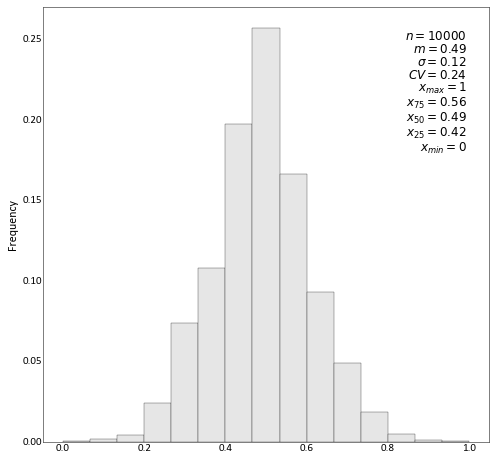

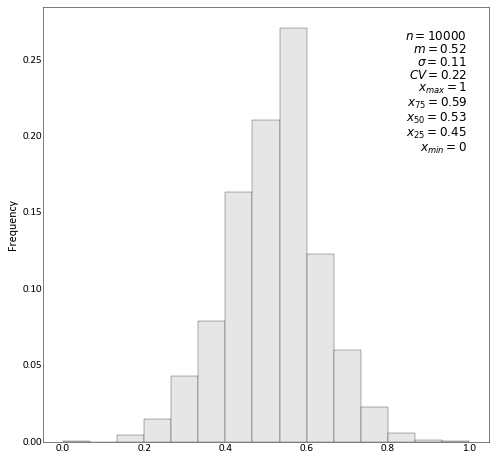

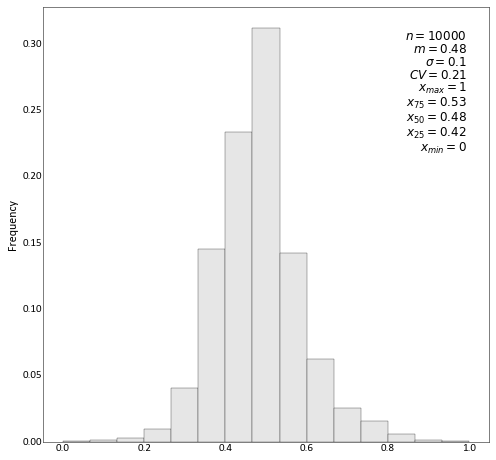

In [13]:
# define a list of the dataset types
data_sets = ['Regular', 'Random', 'Original']

for data_set in data_sets:

    Pred_list = []

    # loop through the files and append to the Pred_list
    for i in range(21):
        g = gs.DataFile('{}/IDW_Rot/IDW_walker_all_U_{}.out'.format(data_set, i))['Estimate']
        Pred_list.append(g)

    Pred_list_2 = []
    for i in range(21):
        g = coo_matrix((Pred_list[i], (row, col)), shape=(100,100)).toarray()
        Pred_list_2.append(g)

    X_train = np.array([Pred_list_2[k] for k in range(21)])

    fi_min = []
    for i in range(21):
        g_min = X_train[i].min()
        fi_min.append(g_min)

    fi_max = []
    for i in range(21):
        g_max = X_train[i].max()
        fi_max.append(g_max)

    fi_norm = []
    for i in range(21):
        g_norm = (X_train[i] - fi_min[i]) / (fi_max[i] - fi_min[i]) * 2 - 1
        fi_norm.append(g_norm)

    X_train_norm = np.array([fi_norm[i] for i in range(21)])

    fi_min_norm = []
    for i in range(21):
        g_min_norm = X_train_norm[i].min()
        fi_min_norm.append(g_min_norm)

    fi_max_norm = []
    for i in range(21):
        g_max_norm = X_train_norm[i].max()
        fi_max_norm.append(g_max_norm)

    fi_norm_2 = []
    for i in range(21):
        g_norm_2 = (X_train_norm[i] - fi_min_norm[i]) / (fi_max_norm[i] - fi_min_norm[i])
        fi_norm_2.append(g_norm_2)

    X_train_norm_2 = np.array([fi_norm_2[i] for i in range(21)])

    gs.histogram_plot(X_train_norm_2[1].reshape(10000))

    X_train_norm_2 = X_train_norm_2.reshape(21, 100, 100, 1)

    Pred_Rot_U = (CNN_Minor.predict(X_train_norm_2))

    fi = []
    for i in range(21):
        g = np.array([ind, co, Pred_Rot_U[i]]).T
        fi.append(g)

    fi_2 = []
    for i in range(21):
        g = np.savetxt('Outdir/Pred_Trained_Minor_{}/Pred_{}_{}.dat'.format(data_set, data_set, i), fi[i], delimiter=" ",comments='')
        fi_2.append(g)

    fi = []
    for i in range(21):
        g = open_vmodel('Outdir/Pred_Trained_Minor_{}/Pred_{}_{}.dat'.format(data_set, data_set, i),n_lag=13)
        fi.append(g)


# Plot results 

In [14]:
var_type = ('Major', 'Minor')
data_sets = ['Regular', 'Random', 'Original']

In [15]:
for i in var_type:
    for k in data_sets:
        for j in range (20): 
            globals()[f'values_{i}_{k}_{j}'] = []

In [16]:
for i in var_type:
    for k in data_sets:
        for j in range (20):
            g = open_vmodel(f'Outdir/Pred_Trained_{i}_{k}/Pred_{k}_{j}.dat'.format(),n_lag=13)['Variogram Value']
            globals()[f'values_{i}_{k}_{j}'].append (g)

In [17]:
nreal = 20
nlags = 13 
nreal = 20

In [18]:
var_type = ('Major', 'Minor')
data_sets = ['Regular', 'Random', 'Original']

nreal = 20
max_values = {}

for var in var_type:
    for data_set in data_sets:
        max_values[f'max_values_{var}_{data_set}'] = []
        for j in range(13):
            values_j = []
            for i in range(nreal):
                g = globals()[f'values_{var}_{data_set}_{i}'][0][j]
                values_j.append(g)
            max_j = np.max(values_j)
            max_values[f'max_values_{var}_{data_set}'].append(max_j)

for key, value in max_values.items():
    print(key, np.array(value))


max_values_Major_Regular [0.19988948 0.45649511 0.73332781 0.89010543 0.9182725  0.93008399
 0.97806931 0.99700081 0.99961412 0.99983168 0.99976331 0.99999195
 0.99998665]
max_values_Major_Random [0.19560713 0.44386363 0.69970173 0.87065148 0.92975974 0.94863582
 0.98356605 0.99876928 0.99997473 0.99999785 0.99999899 1.
 1.        ]
max_values_Major_Original [0.30847052 0.53388232 0.76161802 0.89773071 0.93337107 0.93814057
 0.97078204 0.99414456 0.99932945 0.99983084 0.99969304 0.99994087
 0.99993074]
max_values_Minor_Regular [0.21416533 0.56294215 0.95149231 0.99998719 1.         0.99999857
 0.99998581 0.99999833 0.99999845 0.9999969  0.99999392 0.9999997
 0.99999082]
max_values_Minor_Random [0.19877952 0.52200067 0.85218745 0.9989599  0.99999791 0.99999815
 0.99999416 0.99999821 0.9999873  0.99976498 0.99981272 0.99999577
 0.99996316]
max_values_Minor_Original [0.35149109 0.6351217  0.91282934 0.99969876 0.99999982 0.99999899
 0.99999917 1.         1.         0.99999839 0.99999768 1

In [19]:
var_type = ('Major', 'Minor')
data_sets = ['Regular', 'Random', 'Original']

nreal = 20
min_values = {}

for var in var_type:
    for data_set in data_sets:
        min_values[f'min_values_{var}_{data_set}'] = []
        for j in range(13):
            values_j = []
            for i in range(nreal):
                g = globals()[f'values_{var}_{data_set}_{i}'][0][j]
                values_j.append(g)
            min_j = np.min(values_j)
            min_values[f'min_values_{var}_{data_set}'].append(min_j)

for key, value in min_values.items():
    print(key, np.array(value))


min_values_Major_Regular [0.15059546 0.3641938  0.57200867 0.72101343 0.81027555 0.85382259
 0.86886513 0.90035462 0.93779576 0.96269184 0.97632092 0.98656261
 0.98453635]
min_values_Major_Random [0.13735574 0.35424066 0.58002609 0.74414337 0.84170687 0.88362473
 0.90733075 0.94338739 0.98454106 0.99824226 0.99977797 0.99970657
 0.99945843]
min_values_Major_Original [0.24380085 0.44081059 0.63034713 0.7693004  0.83599877 0.8594287
 0.87328362 0.91135305 0.95506245 0.97386861 0.96897089 0.96021897
 0.95186794]
min_values_Minor_Regular [0.15466926 0.48921436 0.86707652 0.99969572 0.99983585 0.99810898
 0.9852047  0.98092806 0.98141384 0.98143405 0.9917025  0.99800384
 0.99922693]
min_values_Minor_Random [0.15055373 0.44743496 0.77328801 0.98751515 0.99994421 0.99980962
 0.99699461 0.97791636 0.90893471 0.91499203 0.95162523 0.95872611
 0.9825139 ]
min_values_Minor_Original [0.31662616 0.59739959 0.85471761 0.98421192 0.99941373 0.99888504
 0.99778247 0.99628711 0.99533117 0.99807048 0.99

# Load original variogram 

In [20]:
for data_set in data_sets:
    globals()[f'Variogram_Major_{data_set}'] = gs.DataFile(f"{data_set}/{data_set}_Variogram/varcalc160.out")

In [21]:
for data_set in data_sets:
    globals()[f'Variogram_Minor_{data_set}'] = gs.DataFile(f"{data_set}/{data_set}_Variogram/varcalc70.out")

In [22]:
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 300)

## Regular 

In [23]:
dhs_V = gs.DataFile ('Regular/NS_New_WL_DHS_Reg.out', x = 'X', y = 'Y', readfl = True)
display (dhs_V.head ())

,X,Y,Z,value,NS_value
0,0.5,0.5,0.5,0.000000,-2.67379
1,5.5,0.5,0.5,0.000000,-2.37603
2,10.5,0.5,0.5,204.054993,-0.10989
3,15.5,0.5,0.5,157.588303,-0.34180
4,20.5,0.5,0.5,210.154999,-0.06585


## Random 

In [24]:
dhs_Rand_V = gs.DataFile ('Random/NS_New_WL_DHS_Rand.out', x = 'X', y = 'Y', readfl = True)
display (dhs_Rand_V.head ())

,X,Y,Z,value,NS_value
0,47.770000,30.670000,0.5,165.458893,-0.28911
1,9.870000,72.339996,0.5,227.343399,0.05957
2,7.600000,96.019997,0.5,176.246704,-0.21150
3,45.610001,28.590000,0.5,162.413300,-0.29565
4,15.590000,18.379999,0.5,609.767822,1.41353


## Original 

In [25]:
Or_100 = gs.DataFile ('Original/NS_WL_Original_sampling_100.out', x = 'X', y = 'Y', readfl = True)
display (Or_100.head ())

,X,Y,U,V,NS_V
0,1.639344,0.352113,0.022,0.00,-3.07181
1,0.409836,8.098592,0.000,0.00,-2.55436
2,0.819672,14.436620,10.858,224.40,-0.54594
3,0.409836,21.830986,0.000,0.00,-1.89990
4,0.819672,29.225352,21.879,412.08,-0.02934


C:\Users\amokdad\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


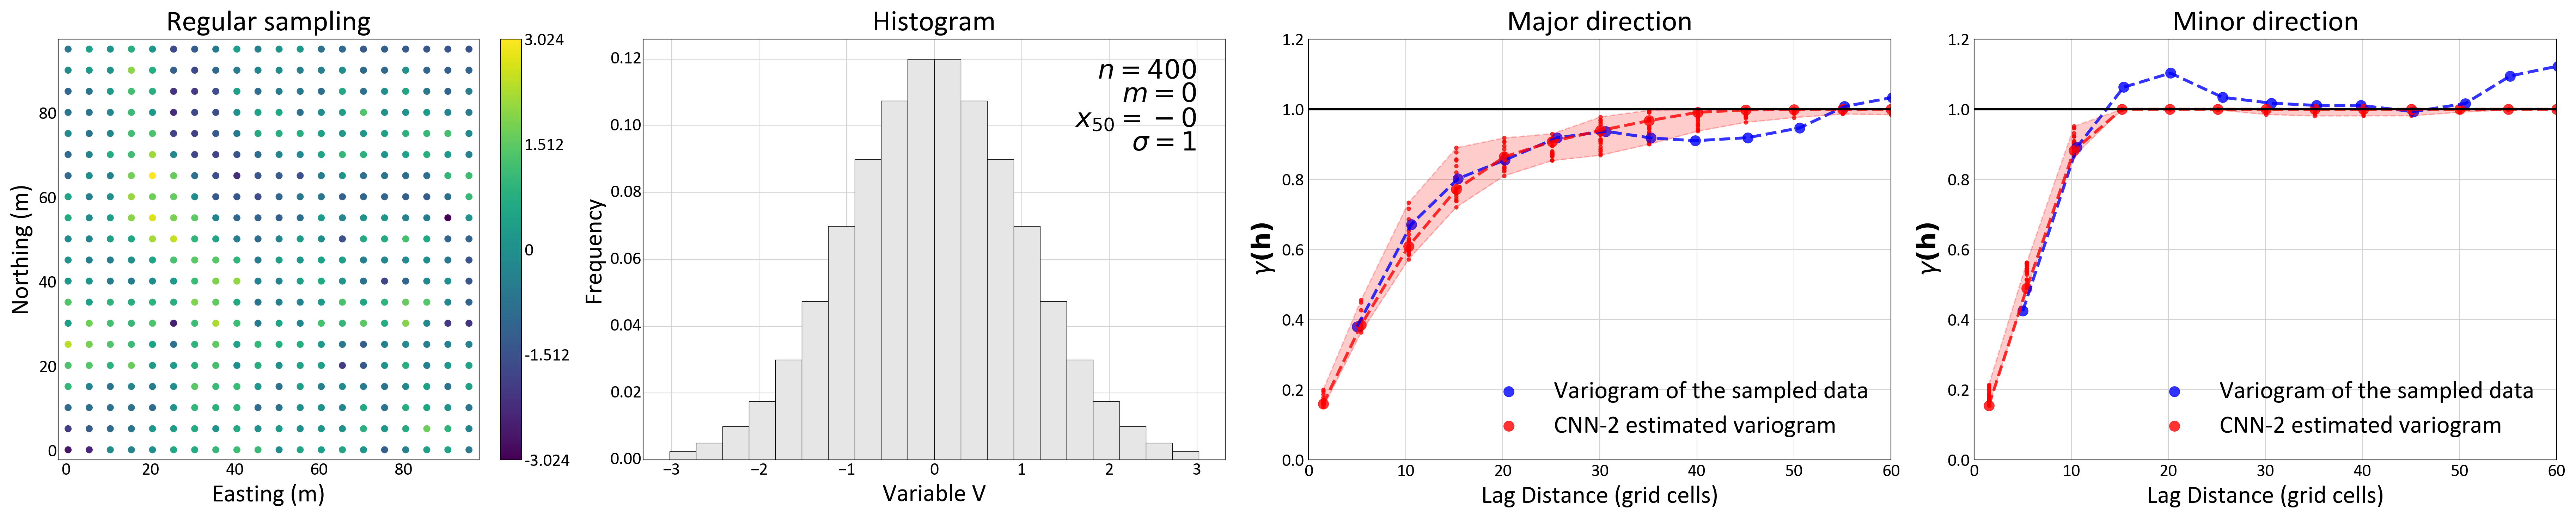

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Set parameters for all plots
params = {'legend.fontsize': 'large', 'axes.labelsize': 'large', 'axes.titlesize':'large',
         'xtick.labelsize':'large', 'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Create figure with 4 columns and 1 row
fig, axes = plt.subplots(1, 4, dpi=300, figsize=(5, 5))

# First row, first figure
gs.location_plot(dhs_V, var='NS_value', orient='xy', title='', sigfigs=4,  
                  plot_style=True, ax=axes[0],figsize=(4,4))
axes[0].set_title('Regular sampling', fontsize=20)
axes[0].set_xlabel('Easting (m)',fontsize=17);
axes[0].set_ylabel('Northing (m)',fontsize=17)
# First row, second figure
gs.histogram_plot(dhs_V, var='NS_value', bins=20, stat_blk='minimal', ax=axes[1], stat_fontsize=18,figsize=(1,4))
axes[1].set_title('Histogram', fontsize=20)
axes[1].set_xlabel('Variable V',fontsize=17);
axes[1].set_ylabel('Frequency',fontsize=17)
axes[1].grid(True)
# Second row, first figure
nreal = 20 
for i in range(nreal):
    axes[2].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Major_Regular_{i}']).reshape(13), 
                     marker='o', color='red', s=7, alpha=0.8)
    


axes[2].scatter(Variogram_Major_Regular['Lag Distance'], Variogram_Major_Regular['Variogram Value'], 
                 marker='o', color='blue', s=50, alpha=0.8, label='Variogram of the sampled data')
axes[2].plot(Variogram_Major_Regular['Lag Distance'], Variogram_Major_Regular['Variogram Value'], 
             color='blue', linewidth=2, alpha=0.8, linestyle='--')

axes[2].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Major_Regular_{i}']).reshape(13), 
                 marker='o', color='red', s=50, alpha=0.8, label='CNN-2 estimated variogram')
axes[2].plot(fi[0]['Lag Distance'], np.array(globals()[f'values_Major_Regular_{i}']).reshape(13), 
             color='red', linewidth=2, alpha=0.8, linestyle='--')
axes[2].fill_between(fi[1]['Lag Distance'], max_values['max_values_Major_Regular'], 
                      min_values['min_values_Major_Regular'], color='red', alpha=0.2)

axes[2].legend(loc='lower right', fontsize=17, frameon=False)
axes[2].plot(fi[1]['Lag Distance'], max_values['max_values_Major_Regular'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')
axes[2].plot(fi[1]['Lag Distance'], min_values['min_values_Major_Regular'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')

axes[2].set_title('Major direction', fontsize=20)
axes[2].set_xlabel('Lag Distance (grid cells)',fontsize=17);
axes[2].set_ylim(0,1.2) 
axes[2].set_ylabel(r'$\gamma \bf(h)$',fontsize=17)

axes[2].plot([0,60],[1.0,1.0],color='black')
axes[2].set_xlim(0,60)
axes[2].grid(True)

axes[2].figure.set_size_inches(25, 5)


# Third row, first figure
nreal = 20 
for i in range(nreal):
    axes[3].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Minor_Regular_{i}']).reshape(13), 
                     marker='o', color='red', s=7, alpha=0.8)
    


axes[3].scatter(Variogram_Minor_Regular['Lag Distance'], Variogram_Minor_Regular['Variogram Value'], 
                 marker='o', color='blue', s=50, alpha=0.8, label='Variogram of the sampled data')
axes[3].plot(Variogram_Minor_Regular['Lag Distance'], Variogram_Minor_Regular['Variogram Value'], 
             color='blue', linewidth=2, alpha=0.8, linestyle='--')

axes[3].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Minor_Regular_{i}']).reshape(13), 
                 marker='o', color='red', s=50, alpha=0.8, label='CNN-2 estimated variogram')
axes[3].plot(fi[0]['Lag Distance'], np.array(globals()[f'values_Minor_Regular_{i}']).reshape(13), 
             color='red', linewidth=2, alpha=0.8, linestyle='--')
axes[3].fill_between(fi[1]['Lag Distance'], max_values['max_values_Minor_Regular'], 
                      min_values['min_values_Minor_Regular'], color='red', alpha=0.2)

axes[3].legend(loc='lower right', fontsize=17, frameon=False)
axes[3].plot(fi[1]['Lag Distance'], max_values['max_values_Minor_Regular'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')
axes[3].plot(fi[1]['Lag Distance'], min_values['min_values_Minor_Regular'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')

axes[3].set_title('Minor direction', fontsize=20)
axes[3].set_xlabel('Lag Distance (grid cells)',fontsize=17);
axes[3].set_ylabel(r'$\gamma \bf(h)$',fontsize=17)
axes[3].set_ylim(0,1.2) 
axes[3].plot([0,60],[1.0,1.0],color='black')
axes[3].set_xlim(0,60)
axes[3].grid(True)


axes[3].figure.set_size_inches(25, 5)

plt.tight_layout()
plt.savefig('Wf_2_Regular.png')
plt.savefig('Wf_2_Regular.pdf')
plt.savefig('Wf_2_Regular.svg')

plt.show()


C:\Users\amokdad\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


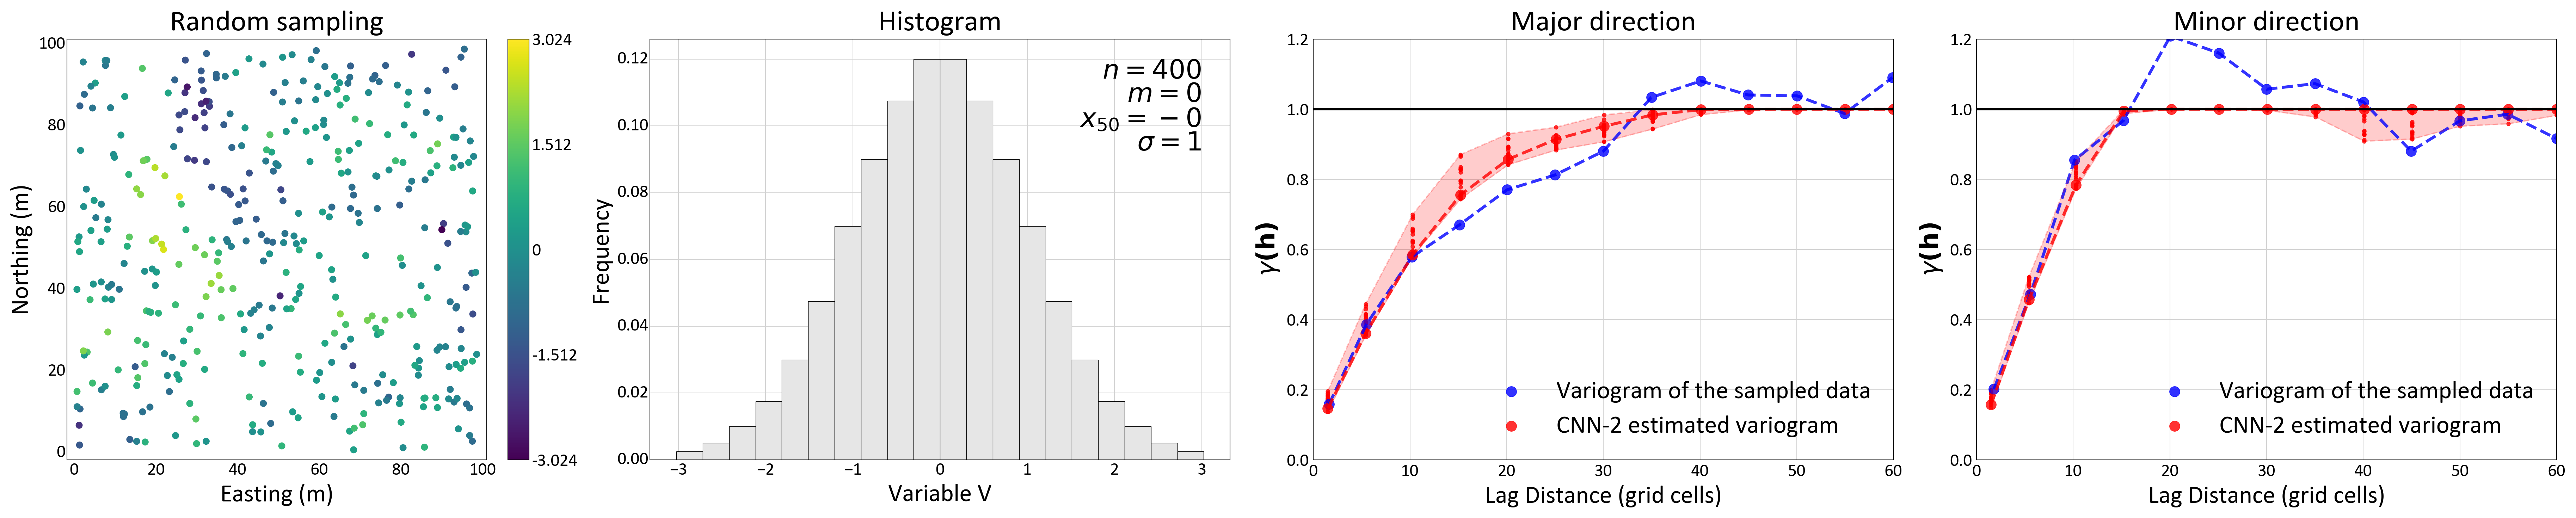

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Set parameters for all plots
params = {'legend.fontsize': 'large', 'axes.labelsize': 'large', 'axes.titlesize':'large',
         'xtick.labelsize':'large', 'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Create figure with 4 columns and 1 row
fig, axes = plt.subplots(1, 4, dpi=300, figsize=(5, 5))

# First row, first figure
gs.location_plot(dhs_Rand_V , var='NS_value', orient='xy', title='', sigfigs=4, 
                  plot_style=True, ax=axes[0],figsize=(4,4))
axes[0].set_title('Random sampling', fontsize=20)
axes[0].set_xlabel('Easting (m)',fontsize=17);
axes[0].set_ylabel('Northing (m)',fontsize=17)
# First row, second figure
gs.histogram_plot(dhs_Rand_V, var='NS_value', bins=20, stat_blk='minimal', ax=axes[1], stat_fontsize=18,figsize=(1,4))
axes[1].set_title('Histogram', fontsize=20)
axes[1].set_xlabel('Variable V',fontsize=17);
axes[1].set_ylabel('Frequency',fontsize=17)
axes[1].grid(True)
# Second row, first figure
nreal = 20 
for i in range(nreal):
    axes[2].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Major_Random_{i}']).reshape(13), 
                     marker='o', color='red', s=7, alpha=0.8)
    

axes[2].scatter(Variogram_Major_Random['Lag Distance'], Variogram_Major_Random['Variogram Value'], 
                 marker='o', color='blue', s=50, alpha=0.8, label='Variogram of the sampled data')
axes[2].plot(Variogram_Major_Random['Lag Distance'], Variogram_Major_Random['Variogram Value'], 
             color='blue', linewidth=2, alpha=0.8, linestyle='--')

axes[2].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Major_Random_{i}']).reshape(13), 
                 marker='o', color='red', s=50, alpha=0.8, label='CNN-2 estimated variogram')
axes[2].plot(fi[0]['Lag Distance'], np.array(globals()[f'values_Major_Random_{i}']).reshape(13), 
             color='red', linewidth=2, alpha=0.8, linestyle='--')
axes[2].fill_between(fi[1]['Lag Distance'], max_values['max_values_Major_Random'], 
                      min_values['min_values_Major_Random'], color='red', alpha=0.2)

axes[2].legend(loc='lower right', fontsize=17, frameon=False)
axes[2].plot(fi[1]['Lag Distance'], max_values['max_values_Major_Random'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')
axes[2].plot(fi[1]['Lag Distance'], min_values['min_values_Major_Random'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')

axes[2].set_title('Major direction', fontsize=20)
axes[2].set_xlabel('Lag Distance (grid cells)',fontsize=17);
axes[2].set_ylim(0,1.2) 
axes[2].set_ylabel(r'$\gamma \bf(h)$',fontsize=17)

axes[2].plot([0,60],[1.0,1.0],color='black')
axes[2].set_xlim(0,60)
axes[2].grid(True)

axes[2].figure.set_size_inches(25, 5)


# Third row, first figure
nreal = 20 
for i in range(nreal):
    axes[3].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Minor_Random_{i}']).reshape(13), 
                     marker='o', color='red', s=7, alpha=0.8)
    


axes[3].scatter(Variogram_Minor_Random['Lag Distance'], Variogram_Minor_Random['Variogram Value'], 
                 marker='o', color='blue', s=50, alpha=0.8, label='Variogram of the sampled data')
axes[3].plot(Variogram_Minor_Random['Lag Distance'], Variogram_Minor_Random['Variogram Value'], 
             color='blue', linewidth=2, alpha=0.8, linestyle='--')

axes[3].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Minor_Random_{i}']).reshape(13), 
                 marker='o', color='red', s=50, alpha=0.8, label='CNN-2 estimated variogram')
axes[3].plot(fi[0]['Lag Distance'], np.array(globals()[f'values_Minor_Random_{i}']).reshape(13), 
             color='red', linewidth=2, alpha=0.8, linestyle='--')
axes[3].fill_between(fi[1]['Lag Distance'], max_values['max_values_Minor_Random'], 
                      min_values['min_values_Minor_Random'], color='red', alpha=0.2)

axes[3].legend(loc='lower right', fontsize=17, frameon=False)
axes[3].plot(fi[1]['Lag Distance'], max_values['max_values_Minor_Random'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')
axes[3].plot(fi[1]['Lag Distance'], min_values['min_values_Minor_Random'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')

axes[3].set_title('Minor direction', fontsize=20)
axes[3].set_xlabel('Lag Distance (grid cells)',fontsize=17);
axes[3].set_ylabel(r'$\gamma \bf(h)$',fontsize=17)
axes[3].set_ylim(0,1.2) 
axes[3].plot([0,60],[1.0,1.0],color='black')
axes[3].set_xlim(0,60)
axes[3].grid(True)


axes[3].figure.set_size_inches(25, 5)
plt.tight_layout()
plt.savefig('Wf_2_Random.png')
plt.savefig('Wf_2_Random.pdf')
plt.savefig('Wf_2_Random.svg')



plt.show()


C:\Users\amokdad\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


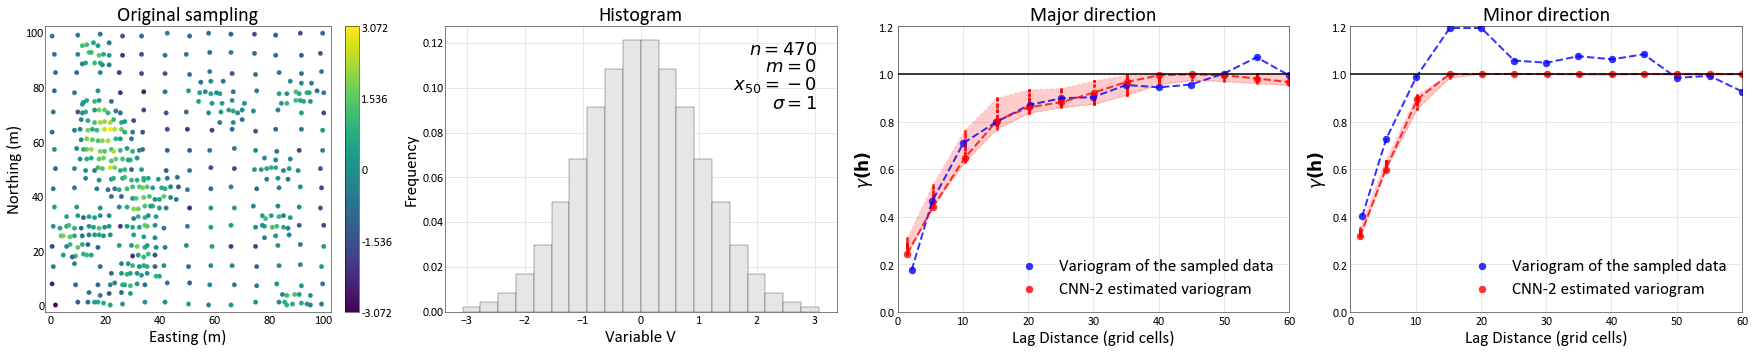

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Set parameters for all plots
params = {'legend.fontsize': 'large', 'axes.labelsize': 'large', 'axes.titlesize':'large',
         'xtick.labelsize':'large', 'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Create figure with 4 columns and 1 row
fig, axes = plt.subplots(1, 4, figsize=(10,10))

# First row, first figure
gs.location_plot(Or_100, var='NS_V', orient='xy', title='', sigfigs=4,  
                  plot_style=True, ax=axes[0],figsize=(4,4))
axes[0].set_title('Original sampling', fontsize=20)
axes[0].set_xlabel('Easting (m)',fontsize=17);
axes[0].set_ylabel('Northing (m)',fontsize=17)
# First row, second figure
gs.histogram_plot(Or_100, var='NS_V', bins=20, stat_blk='minimal', ax=axes[1], stat_fontsize=18,figsize=(1,4))
axes[1].set_title('Histogram', fontsize=20)
axes[1].set_xlabel('Variable V',fontsize=17);
axes[1].set_ylabel('Frequency',fontsize=17)
axes[1].grid(True)
# Second row, first figure
nreal = 20 
for i in range(nreal):
    axes[2].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Major_Original_{i}']).reshape(13), 
                     marker='o', color='red', s=7, alpha=0.8)
    


axes[2].scatter(Variogram_Major_Original['Lag Distance'], Variogram_Major_Original['Variogram Value'], 
                 marker='o', color='blue', s=50, alpha=0.8, label='Variogram of the sampled data')
axes[2].plot(Variogram_Major_Original['Lag Distance'], Variogram_Major_Original['Variogram Value'], 
             color='blue', linewidth=2, alpha=0.8, linestyle='--')

axes[2].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Major_Original_{i}']).reshape(13), 
                 marker='o', color='red', s=50, alpha=0.8, label='CNN-2 estimated variogram')
axes[2].plot(fi[0]['Lag Distance'], np.array(globals()[f'values_Major_Original_{i}']).reshape(13), 
             color='red', linewidth=2, alpha=0.8, linestyle='--')
axes[2].fill_between(fi[1]['Lag Distance'], max_values['max_values_Major_Original'], 
                      min_values['min_values_Major_Original'], color='red', alpha=0.2)

axes[2].legend(loc='lower right', fontsize=17, frameon=False)
axes[2].plot(fi[1]['Lag Distance'], max_values['max_values_Major_Original'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')
axes[2].plot(fi[1]['Lag Distance'], min_values['min_values_Major_Original'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')

axes[2].set_title('Major direction', fontsize=20)
axes[2].set_xlabel('Lag Distance (grid cells)',fontsize=17);
axes[2].set_ylim(0,1.2) 
axes[2].set_ylabel(r'$\gamma \bf(h)$',fontsize=17)

axes[2].plot([0,60],[1.0,1.0],color='black')
axes[2].set_xlim(0,60)
axes[2].grid(True)

axes[2].figure.set_size_inches(25,5)


# Third row, first figure
nreal = 20 
for i in range(nreal):
    axes[3].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Minor_Original_{i}']).reshape(13), 
                     marker='o', color='red', s=7, alpha=0.8)
    


axes[3].scatter(Variogram_Minor_Original['Lag Distance'], Variogram_Minor_Original['Variogram Value'], 
                 marker='o', color='blue', s=50, alpha=0.8, label='Variogram of the sampled data')
axes[3].plot(Variogram_Minor_Original['Lag Distance'], Variogram_Minor_Original['Variogram Value'], 
             color='blue', linewidth=2, alpha=0.8, linestyle='--')

axes[3].scatter(fi[0]['Lag Distance'], np.array(globals()[f'values_Minor_Original_{i}']).reshape(13), 
                 marker='o', color='red', s=50, alpha=0.8, label='CNN-2 estimated variogram')
axes[3].plot(fi[0]['Lag Distance'], np.array(globals()[f'values_Minor_Original_{i}']).reshape(13), 
             color='red', linewidth=2, alpha=0.8, linestyle='--')
axes[3].fill_between(fi[1]['Lag Distance'], max_values['max_values_Minor_Original'], 
                      min_values['min_values_Minor_Original'], color='red', alpha=0.2)

axes[3].legend(loc='lower right', fontsize=17, frameon=False)
axes[3].plot(fi[1]['Lag Distance'], max_values['max_values_Minor_Original'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')
axes[3].plot(fi[1]['Lag Distance'], min_values['min_values_Minor_Original'], color='red', 
             linewidth=1, alpha=0.2, linestyle='--')

axes[3].set_title('Minor direction', fontsize=20)
axes[3].set_xlabel('Lag Distance (grid cells)',fontsize=17);
axes[3].set_ylabel(r'$\gamma \bf(h)$',fontsize=17)
axes[3].set_ylim(0,1.2) 
axes[3].plot([0,60],[1.0,1.0],color='black')
axes[3].set_xlim(0,60)
axes[3].grid(True)


axes[3].figure.set_size_inches(25,5)
plt.tight_layout()
plt.savefig('Wf_2_Original.png')
plt.savefig('Wf_2_Original.pdf')
plt.savefig('Wf_2_Original.svg')




plt.show()
